# Impor libraries

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import gzip
import shutil
import glob

/lustre/work/client/users/jvbritt/.conda/envs/ds_1300/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Load data

In [3]:
#Annual Resident Population Estimates for Metropolitan/Micropolitan Statistical Areas (https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-metro-and-micro-statistical-areas.html first dataset)

popData = pd.read_csv("data/cbsa-est2022.csv", encoding="latin-1")
popData = popData[['CBSA', 'NAME', 'LSAD', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']]
popData

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308
1,10180,"Callahan County, TX",County or equivalent,13744,14078,14210
2,10180,"Jones County, TX",County or equivalent,19678,19809,19935
3,10180,"Taylor County, TX",County or equivalent,143444,143942,145163
4,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627
...,...,...,...,...,...,...
2794,49460,"Yankton County, SD",County or equivalent,23282,23334,23373
2795,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113
2796,49780,"Muskingum County, OH",County or equivalent,86450,86574,86113
2797,49820,"Zapata, TX",Micropolitan Statistical Area,13874,13893,13849


In [6]:
#Load Core Based Statistical Areas (https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-metropolitan-statistical-area-micropolitan-statist)
#CRS 3857: https://epsg.io/3857

CBSAs = geopandas.read_file("data/metro_shp/tl_2019_us_cbsa.shp").to_crs(3857)
CBSAs = CBSAs[['CBSAFP', 'NAME', 'geometry']]
CBSAs['CBSAFP'] = CBSAs['CBSAFP'].astype(int)
CBSAs

,CBSAFP,NAME,geometry
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0..."
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7..."
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2..."
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4..."
...,...,...,...
933,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783..."
934,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215..."
935,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142..."
936,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5..."


In [7]:
#Load states shapefile (for plotting) (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html under States)

statesShp = geopandas.read_file("data/state_shp/cb_2018_us_state_500k.shp").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [8]:
#Download LODES data for orgin-destination travel (how many people commute from place X to place Y)

states = ['al', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la',
          'me', 'md', 'ma', 'mi', 'mn', 'mo', 'ms', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok',
          'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"

folder_name = "data/LODES"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for state in states:
    if state == 'ak':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2016.csv.gz"
        file_name = state + "_od_main_JT00_2016.csv.gz"
    elif state == 'ar':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2019.csv.gz"
        file_name = state + "_od_main_JT00_2019.csv.gz"
    elif state == 'ms':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2018.csv.gz"
        file_name = state + "_od_main_JT00_2018.csv.gz"
    else:
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2020.csv.gz"
        file_name = state + "_od_main_JT00_2020.csv.gz"
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print("Download complete.")
    
    # Unzip the file
    unzipped_file_name = file_name[:-3]  # Remove '.gz' extension
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    os.remove(file_path)
    print("Deleted", file_name)

Download complete.
Unzipped al_od_main_JT00_2020.csv
Deleted al_od_main_JT00_2020.csv.gz
Download complete.
Unzipped ak_od_main_JT00_2016.csv
Deleted ak_od_main_JT00_2016.csv.gz
Download complete.
Unzipped ar_od_main_JT00_2019.csv
Deleted ar_od_main_JT00_2019.csv.gz
Download complete.
Unzipped az_od_main_JT00_2020.csv
Deleted az_od_main_JT00_2020.csv.gz
Download complete.
Unzipped ca_od_main_JT00_2020.csv
Deleted ca_od_main_JT00_2020.csv.gz
Download complete.
Unzipped co_od_main_JT00_2020.csv
Deleted co_od_main_JT00_2020.csv.gz
Download complete.
Unzipped ct_od_main_JT00_2020.csv
Deleted ct_od_main_JT00_2020.csv.gz
Download complete.
Unzipped de_od_main_JT00_2020.csv
Deleted de_od_main_JT00_2020.csv.gz
Download complete.
Unzipped fl_od_main_JT00_2020.csv
Deleted fl_od_main_JT00_2020.csv.gz
Download complete.
Unzipped ga_od_main_JT00_2020.csv
Deleted ga_od_main_JT00_2020.csv.gz
Download complete.
Unzipped hi_od_main_JT00_2020.csv
Deleted hi_od_main_JT00_2020.csv.gz
Download complete.
Un

In [9]:
#Download crosswalk data (which CBSAs contain which blocks/block groups)

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"
folder_name = "data/LODES_XWALK"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for state in states:
    
    file_url = base_url + state + "/" + state + "_xwalk.csv.gz"
    file_name = state + "_xwalk.csv.gz"
    
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    
    print("Download complete.")
    
    unzipped_file_name = file_name[:-3]
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    
    os.remove(file_path)
    
    print("Deleted", file_name)

Download complete.
Unzipped al_xwalk.csv
Deleted al_xwalk.csv.gz
Download complete.
Unzipped ak_xwalk.csv
Deleted ak_xwalk.csv.gz
Download complete.
Unzipped ar_xwalk.csv
Deleted ar_xwalk.csv.gz
Download complete.
Unzipped az_xwalk.csv
Deleted az_xwalk.csv.gz
Download complete.
Unzipped ca_xwalk.csv
Deleted ca_xwalk.csv.gz
Download complete.
Unzipped co_xwalk.csv
Deleted co_xwalk.csv.gz
Download complete.
Unzipped ct_xwalk.csv
Deleted ct_xwalk.csv.gz
Download complete.
Unzipped de_xwalk.csv
Deleted de_xwalk.csv.gz
Download complete.
Unzipped fl_xwalk.csv
Deleted fl_xwalk.csv.gz
Download complete.
Unzipped ga_xwalk.csv
Deleted ga_xwalk.csv.gz
Download complete.
Unzipped hi_xwalk.csv
Deleted hi_xwalk.csv.gz
Download complete.
Unzipped id_xwalk.csv
Deleted id_xwalk.csv.gz
Download complete.
Unzipped il_xwalk.csv
Deleted il_xwalk.csv.gz
Download complete.
Unzipped in_xwalk.csv
Deleted in_xwalk.csv.gz
Download complete.
Unzipped ia_xwalk.csv
Deleted ia_xwalk.csv.gz
Download complete.
Unzipp

In [10]:
#Load orgin-destination data (for TX)
stateData = []

for path in glob.glob("data/LODES/*_od_main_JT00_20*.csv"):
    print(".", end="")
    odData = pd.read_csv(path)
    odData = odData[['w_geocode', 'h_geocode', 'S000']]
    stateData.append(odData)

odData = pd.concat(stateData)
odData
#.................................................

..................................................

,w_geocode,h_geocode,S000
0,10010201001001,10010208013004,1
1,10010201001001,10670304002042,1
2,10010201001012,10010201002008,1
3,10010201001012,10010203001003,1
4,10010201001012,10010203001011,1
...,...,...,...
199091,560459513003044,560459513003062,1
199092,560459513003045,560459511002403,1
199093,560459513003050,560459513002016,1
199094,560459513003050,560459513002053,1


In [11]:
#Load crosswalk data (for TX)

stateData = []

for path in glob.glob("data/LODES_XWALK/*_xwalk.csv"):
    print(".", end="")
    xwalk = pd.read_csv(path, low_memory=False)
    xwalk = xwalk[['ctyname', 'bgrp', 'cbsa']]
    stateData.append(xwalk)

xwalk = pd.concat(stateData)
xwalk
#.................................................

..................................................

,ctyname,bgrp,cbsa
0,"Autauga County, AL",10010211002,33860
1,"Tallapoosa County, AL",11239623012,10760
2,"Washington County, AL",11290442004,33660
3,"Winston County, AL",11339656023,99999
4,"Shelby County, AL",11170301021,13820
...,...,...,...
53764,"Sweetwater County, WY",560379716002,40540
53765,"Lincoln County, WY",560239782002,99999
53766,"Sweetwater County, WY",560379705001,40540
53767,"Sweetwater County, WY",560379705001,40540


# Analysis

## Create OD count lookup table
How many people commuted from blockgroup x to blockgroup y = odTable[x, y]

In [12]:
#Extract block group code
odData['h_bgrp'] = (odData['h_geocode'] / 10**3).astype(int)
odData['w_bgrp'] = (odData['w_geocode'] / 10**3).astype(int)

In [13]:
#Lookup table to make finding a blockgroup's cbsa fast
bgrpToCbsa = xwalk.groupby('bgrp').first()['cbsa']
bgrpToCbsa = dict(zip(bgrpToCbsa.index, bgrpToCbsa.values)) #Dict is faster for lookup

In [14]:
#Lookup cbsa for blockgroup
odData['w_cbsa'] = odData['w_bgrp'].apply(lambda c: bgrpToCbsa[c])
odData['h_cbsa'] = odData['h_bgrp'].apply(lambda c: bgrpToCbsa[c])

In [15]:
odTable = odData.groupby(['h_cbsa', 'w_cbsa']).sum()['S000']
odTable

h_cbsa  w_cbsa
10100   10100       15856
        15100         346
        26700         235
        33580         286
        38180         214
                   ...   
99999   49700        1361
        49740         135
        49780        1396
        49820          45
        99999     3408087
Name: S000, Length: 29102, dtype: int64

## Working population lookup table
How many people work in blockgroup x (and commute somewhere) = workingPop[x]

In [16]:
workingPop = odData.groupby(['h_cbsa']).sum()['S000']
workingPop

h_cbsa
10100      19624
10140      28706
10180      66780
10220      15247
10300      32522
          ...   
49700      68007
49740      63974
49780      33194
49820       4216
99999    6268416
Name: S000, Length: 910, dtype: int64

## Main gdf table with data for every CBSA

In [17]:
gdf = pd.merge(popData, CBSAs, on="NAME", how="inner")
gdf = geopandas.GeoDataFrame(gdf)
gdf

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,CBSAFP,geometry
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308,10180,"POLYGON ((-11148262.500 3832132.455, -11148249..."
1,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627,10420,"POLYGON ((-9060481.928 5063847.837, -9060475.5..."
2,10500,"Albany, GA",Metropolitan Statistical Area,148244,144922,145786,10500,"POLYGON ((-9400975.184 3713776.408, -9400980.6..."
3,10540,"Albany-Lebanon, OR",Metropolitan Statistical Area,128978,129948,130467,10540,"POLYGON ((-13720236.776 5551262.937, -13720393..."
4,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,899748,905369,904617,10580,"POLYGON ((-8247992.807 5305256.748, -8248085.6..."
...,...,...,...,...,...,...,...,...
923,49300,"Wooster, OH",Micropolitan Statistical Area,116906,116129,116559,49300,"POLYGON ((-9089178.853 5010653.858, -9088979.1..."
924,49380,"Worthington, MN",Micropolitan Statistical Area,22207,22047,21947,49380,"POLYGON ((-10627927.538 5441934.306, -10627791..."
925,49460,"Yankton, SD",Micropolitan Statistical Area,23282,23334,23373,49460,"POLYGON ((-10855702.126 5337734.746, -10853435..."
926,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113,49780,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


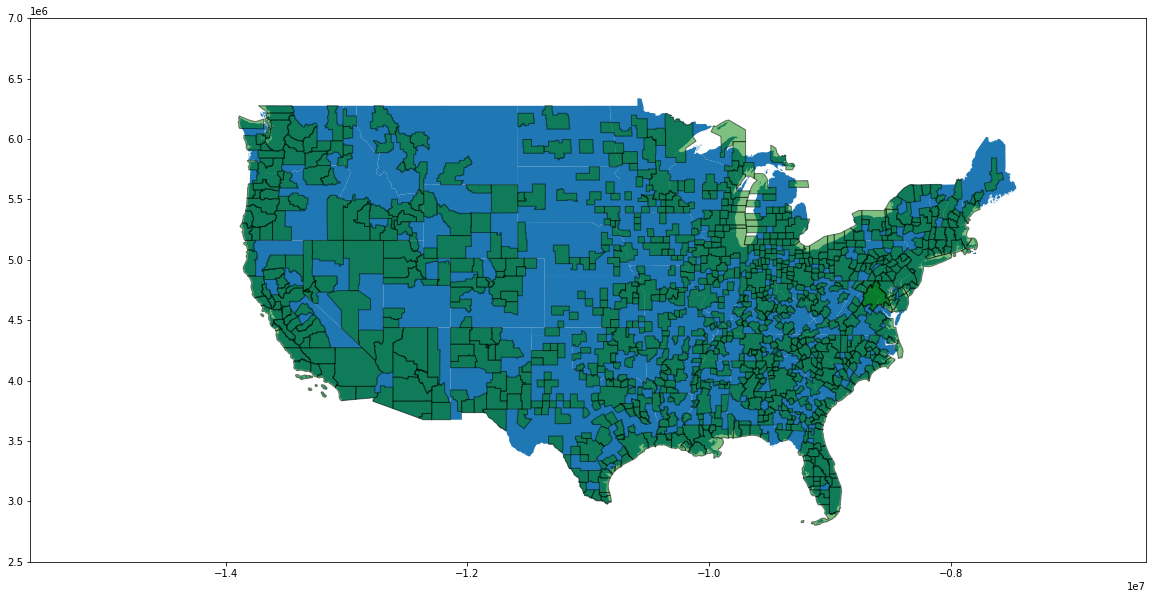

In [18]:
ax = plotUS()
gdf.plot(ax=ax, color="green", edgecolor="black", linewidth=1, alpha=0.5);

## Find large metro areas and small metro/micro areas

In [19]:
#Urban centers are Metropolitan Statistical Areas with population > 1,000,000
#Potential liminal places are Metropolitan/Micropolitan Statistical Areas with population < 100,000

gdf['metro'] = (gdf['POPESTIMATE2021'] > 1_000_000) & (gdf['LSAD'] == 'Metropolitan Statistical Area')
gdf['micro'] = (gdf['POPESTIMATE2021'] < 100_000) & ((gdf['LSAD'] == 'Metropolitan Statistical Area') | (gdf['LSAD'] == 'Micropolitan Statistical Area'))

print(gdf['metro'].sum(), "large metro areas")
print(gdf['micro'].sum(), "small metro/micro areas")

56 large metro areas
536 small metro/micro areas


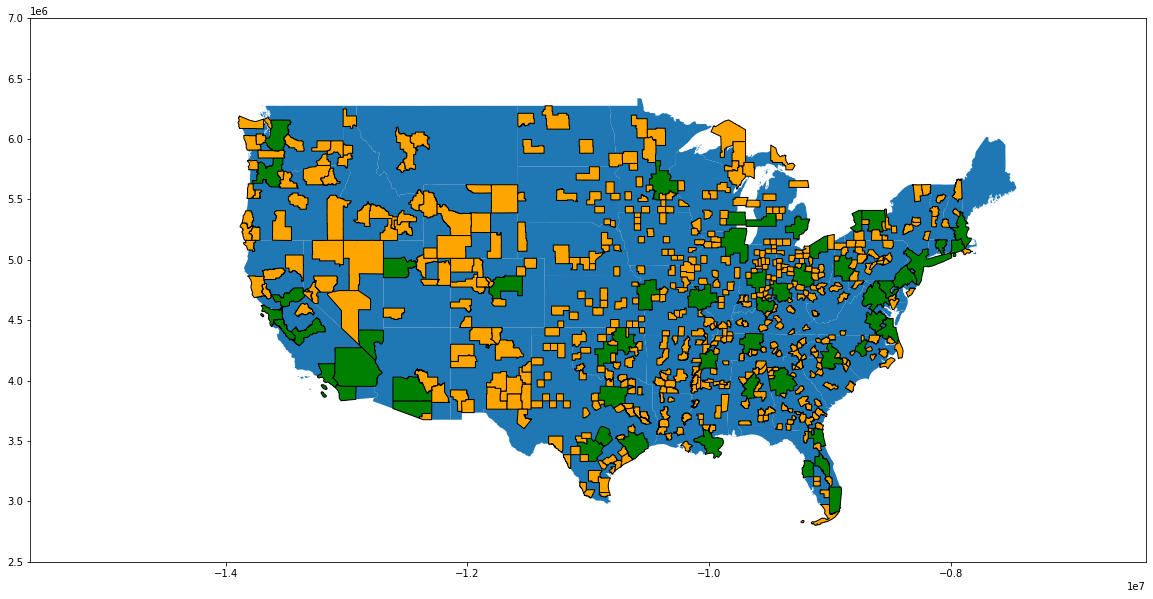

In [20]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

## 100Mi buffer around large metro areas

In [21]:
buffRad = 100 * 1609.34 #100Mi to m
gdf['buff'] = gdf.buffer(buffRad)

In [22]:
# For each area, check if it intersects any metro area

def inBuff(geom):
    # Does geom intersect any metro area?
    # if geom is None:
    #     return False
    for metroArea in gdf[gdf['metro']]['buff']:
        if metroArea.intersects(geom):
            return True
    return False

gdf['inBuff'] = gdf['geometry'].apply(inBuff)

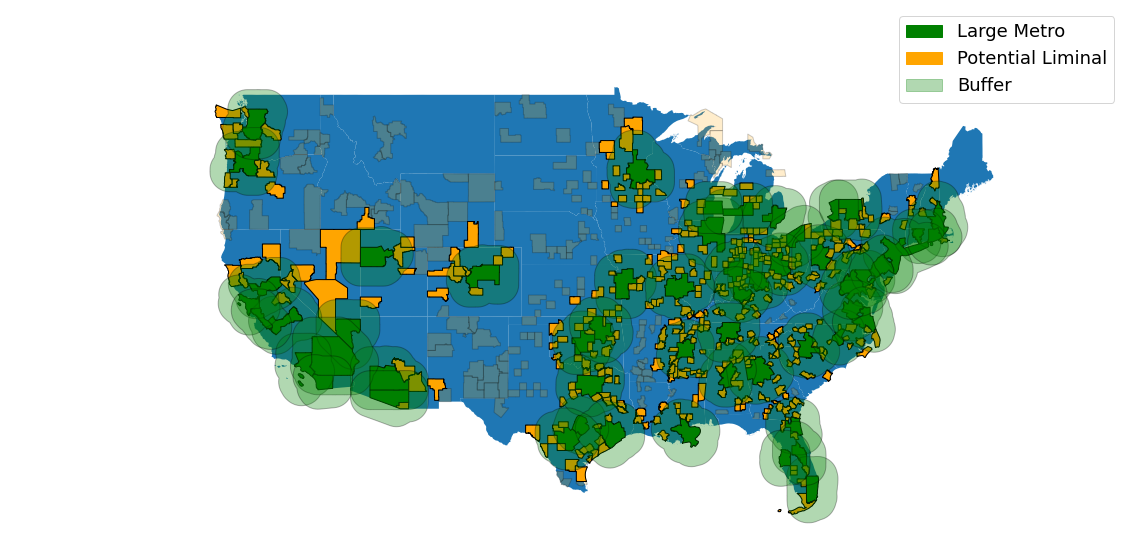

In [25]:
import matplotlib.patches as mpatches

ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1, label='Metro')
gdf[gdf['micro']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1, alpha=0.2, label='Micro')
gdf[gdf['micro'] & gdf['inBuff']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1)
gdf[gdf['metro']]['buff'].plot(ax=ax, color="green", edgecolor="black", linewidth=1, alpha=0.3, label='Buffer')

plt.axis('off')

metro_patch = mpatches.Patch(color='green', label='Large Metro')
micro_patch = mpatches.Patch(color='orange', label='Potential Liminal')
buff_patch = mpatches.Patch(color='green', alpha=0.3, label='Buffer')

plt.legend(handles=[metro_patch, micro_patch, buff_patch], loc='upper right', prop={'size': 18})
plt.savefig("liminal_cities.png")
plt.show()

In [26]:
#Possible liminal places
gdf[gdf['micro'] & gdf['inBuff']][['NAME', 'POPESTIMATE2021']]

,NAME,POPESTIMATE2021
40,"Bloomsburg-Berwick, PA",83083
55,"Cape Girardeau, MO-IL",97757
57,"Carson City, NV",58796
81,"Columbus, IN",82730
84,"Corvallis, OR",96277
...,...,...
917,"Wilson, NC",78283
918,"Winfield, KS",34652
920,"Winona, MN",49750
922,"Woodward, OK",23947


## How many people commute to a nearby large metro area?

In [27]:
def countCommuteBuff(row):
    count = 0
    microId = row['CBSAFP']
    for _, metro in gdf[gdf['metro']].iterrows():
        if metro['buff'].intersects(row['geometry']):
            metroId = metro['CBSAFP']
            try:
                count += odTable[microId, metroId]
            except KeyError:
                pass
    return count

gdf['commuteBuffCount'] = gdf.apply(countCommuteBuff, axis=1)
gdf['workingPop'] = gdf['CBSAFP'].apply(lambda cbsa: workingPop.get(cbsa, float('nan')))
gdf['commutePercent'] = gdf['commuteBuffCount'] / gdf['workingPop'] * 100
gdf

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,CBSAFP,geometry,metro,micro,buff,inBuff,commuteBuffCount,workingPop,commutePercent
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308,10180,"POLYGON ((-11148262.500 3832132.455, -11148249...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649...",True,7146,66780.0,10.700809
1,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627,10420,"POLYGON ((-9060481.928 5063847.837, -9060475.5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.7...",True,86722,306288.0,28.313875
2,10500,"Albany, GA",Metropolitan Statistical Area,148244,144922,145786,10500,"POLYGON ((-9400975.184 3713776.408, -9400980.6...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.8...",True,3686,50430.0,7.309141
3,10540,"Albany-Lebanon, OR",Metropolitan Statistical Area,128978,129948,130467,10540,"POLYGON ((-13720236.776 5551262.937, -13720393...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524...",True,6390,54728.0,11.675925
4,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,899748,905369,904617,10580,"POLYGON ((-8247992.807 5305256.748, -8248085.6...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.1...",True,25289,390058.0,6.483395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,49300,"Wooster, OH",Micropolitan Statistical Area,116906,116129,116559,49300,"POLYGON ((-9089178.853 5010653.858, -9088979.1...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.5...",True,8380,48312.0,17.345587
924,49380,"Worthington, MN",Micropolitan Statistical Area,22207,22047,21947,49380,"POLYGON ((-10627927.538 5441934.306, -10627791...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573...",False,0,9763.0,0.000000
925,49460,"Yankton, SD",Micropolitan Statistical Area,23282,23334,23373,49460,"POLYGON ((-10855702.126 5337734.746, -10853435...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883...",False,0,10222.0,0.000000
926,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113,49780,"POLYGON ((-9149881.580 4868949.855, -9149879.9...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.6...",True,10044,33194.0,30.258480


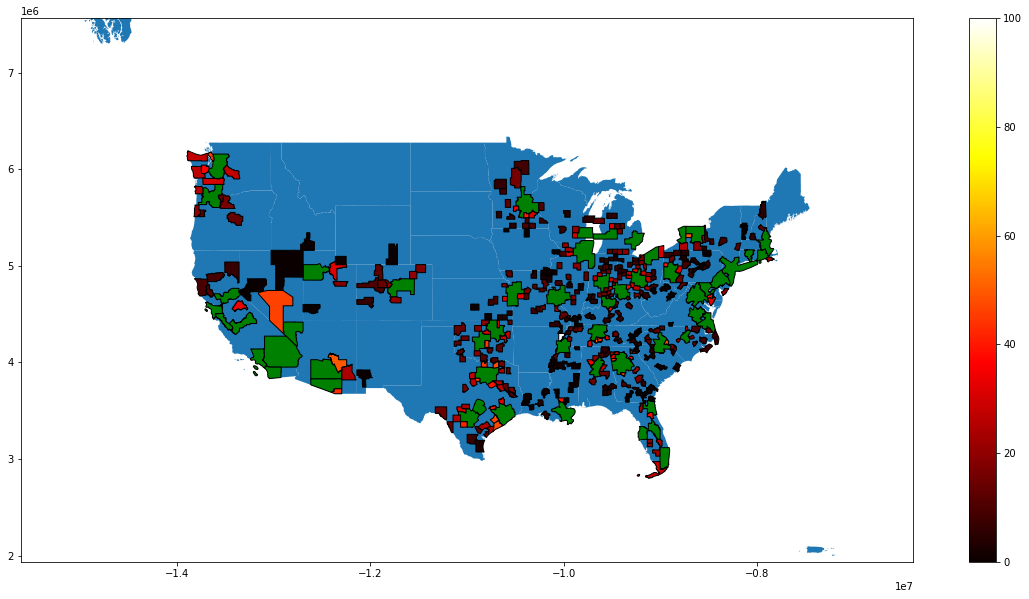

In [28]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff']].plot(column='commutePercent', ax=ax, edgecolor="black", linewidth=1, legend=True, cmap="hot");
plt.savefig("figures/commute_percent.png")

In [ ]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 10)].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

In [ ]:
len(gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 15)])